In [1]:
from __future__ import annotations

In [2]:
import os
import math
import time
import torch
import pickle
import psutil
import pydicom
import numpy as np
from tqdm import tqdm
from typing import Any
import matplotlib.pyplot as plt
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    Compose,
    RandFlip,
    RandRotate,
    ScaleIntensity,
    RandSpatialCrop,
    Randomizable,
    apply_transform,
    ToTensor,
)
from monai.utils import set_determinism
from monai.data import Dataset, DataLoader
from monai.utils import MAX_SEED, get_seed
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
# Set Random Seed For Fair Comparison
global_seed = 42
set_determinism(seed=global_seed)

# Prepare Data

In [4]:
data_dir = '../AAPM_Mayo/Patient_Data'
B30_path = []
D45_path = []
for subject_dir in tqdm(sorted(os.listdir(data_dir)), total=len(os.listdir(data_dir))):
    subject_dir_path = os.path.join(data_dir, subject_dir)
    if not os.path.isdir(subject_dir_path):
        continue
    for kernel_dir in os.listdir(subject_dir_path):
        if 'B30' in kernel_dir:
            B30_path.append(os.path.join(subject_dir_path,kernel_dir))
        if 'D45' in kernel_dir:
            D45_path.append(os.path.join(subject_dir_path,kernel_dir))
B30_path.sort()
D45_path.sort()

100%|██████████| 3/3 [00:00<00:00, 8671.89it/s]


In [5]:
thin_path = []
true_thick_path = []
our_thick_path = []
naive_thick_path = []

In [6]:
for kernel_dir in B30_path:#Specify the kernel folder here  
    if not '1mm' in kernel_dir:# only do the downsampling average on 1mm
        continue
    for dose_dir in os.listdir(kernel_dir):
        if 'f' in dose_dir.lower():
            dose_dir = os.path.join(kernel_dir,dose_dir)
            for case_dir in os.listdir(dose_dir):#[:1]: # only read 1 case for testing
                case_dir = os.path.join(dose_dir, case_dir)
                for repeat_dir in os.listdir(case_dir):
                    case_dir = os.path.join(case_dir, repeat_dir)
                    print(f"Retrieving thin images from: {case_dir}")
                    true_thick_dir = case_dir.replace('1mm', '3mm')
                    thin_path.append(case_dir)
                    true_thick_path.append(true_thick_dir)
                    our_thick_path.append(os.path.join(case_dir, 'thick_images.pickle'))
                    naive_thick_path.append(os.path.join(case_dir, 'naive_thick_images.npy'))

Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L286/full_1mm
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L067/full_1mm
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L506/full_1mm
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L291/full_1mm
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L310/full_1mm
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L109/full_1mm
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L143/full_1mm
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L192/full_1mm
Retrieving thin images from: ../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L333/full_1mm
Retrieving thin images from: ../AAPM_Mayo/Pati

In [7]:
print(thin_path[:1])
print(true_thick_path[:1])
print(our_thick_path[:1])
print(naive_thick_path[:1])

['../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L286/full_1mm']
['../AAPM_Mayo/Patient_Data/Training_Image_Data/3mm B30/full_3mm/L286/full_3mm']
['../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L286/full_1mm/thick_images.pickle']
['../AAPM_Mayo/Patient_Data/Training_Image_Data/1mm B30/full_1mm/L286/full_1mm/naive_thick_images.npy']


In [8]:
val_transforms = Compose([
    ScaleIntensity(minv=-1.0,maxv=1.0),
    ToTensor()
])

In [9]:
class AAPMDataset(Dataset,Randomizable):
        
    def __init__(self, thick_path, thin_path, thick_transforms=None, thin_transforms=None, seed=42):
        self.thick_path = thick_path
        self.thin_path = thin_path
        self.thick_transforms = thick_transforms
        self.thin_transforms = thin_transforms
        self.set_random_state(seed=get_seed())
        self._seed = seed  # transform synchronization seed
        
    def __len__(self):
        return len(self.thick_path)
    
    def randomize(self, data: Any | None = None) -> None:
        self._seed = self.R.randint(MAX_SEED, dtype="uint32")
    
    def __getitem__(self, index):
        self.randomize()
        
        thin_images = [pydicom.dcmread(os.path.join(self.thin_path[index],file_name)) 
                       for file_name in os.listdir(self.thin_path[index]) if file_name.endswith('.IMA')]
        thin_images.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        thin_pixel_data  = np.empty((len(thin_images), 512, 512))
        for i, img in enumerate(thin_images):
            thin_pixel_data[i,:,:] = img.pixel_array
            
        if 'naive' in self.thick_path[index]:
            print('Comparing interpolated naive_TS with thin')
            with open(self.thick_path[index], "rb") as file:
                thick_images_array = np.load(file)
            thick_images = torch.from_numpy(thick_images_array).to(torch.float32)
              
        elif 'pickle' in self.thick_path[index]:
            print('Comparing interpolated OurTS with thin')
            with open(self.thick_path[index], "rb") as file:
                thick_images_array = pickle.load(file)    
            thick_images = thick_images_array
            thick_images = torch.from_numpy(thick_images_array).to(torch.float32)
        else:
            print('Comparing interpolated true thick with thin')
            thick_ds = [pydicom.dcmread(os.path.join(self.thick_path[index],file_name)) for file_name in os.listdir(self.thick_path[index]) if file_name.endswith('.IMA')]
            thick_ds.sort(key=lambda x: float(x.ImagePositionPatient[2]))
            thick_images_array = np.empty((len(thick_ds), 512, 512))
            for i, img in enumerate(thick_ds):
                thick_images_array[i,:,:] = img.pixel_array 
            thick_images = torch.nn.functional.interpolate(torch.unsqueeze(torch.unsqueeze(torch.from_numpy(thick_images_array).to(torch.float32),0),0),
                                                  size=(len(thin_images),512,512),
                                                  mode='trilinear')[0,0,:,:,:]
            
            
        if self.thick_transforms is not None:
            self.thick_transforms.set_random_state(seed=self._seed)
            thick_images = apply_transform(self.thick_transforms,torch.unsqueeze(thick_images,0),map_items=False)
        if self.thin_transforms is not None:
            self.thin_transforms.set_random_state(seed=self._seed)
            thin_pixel_data = apply_transform(self.thin_transforms,np.expand_dims(thin_pixel_data,0),map_items=False)
            
        return thick_images, thin_pixel_data

In [10]:
val_ds = AAPMDataset(naive_thick_path, true_thick_path, val_transforms, val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)

In [11]:
def rmse(candidate: np.ndarray, reference: np.ndarray) -> float:
    return math.sqrt(mse(candidate, reference))

In [14]:
RMSE = []
PSNR = []
for val_data in tqdm(val_loader,total=len(val_loader)):
    val_thick, val_thin = val_data[0], val_data[1]
    try:
        RMSE.append(rmse(val_thin.numpy(),val_thick.numpy()))
        PSNR.append(psnr(val_thin.numpy(),val_thick.numpy()))
    except:
        print('detect unmatched dimension')

  0%|          | 0/10 [00:00<?, ?it/s]

Comparing interpolated naive_TS with thin
Comparing interpolated naive_TS with thin


 10%|█         | 1/10 [00:01<00:12,  1.39s/it]

Comparing interpolated naive_TS with thin


 20%|██        | 2/10 [00:01<00:06,  1.24it/s]

Comparing interpolated naive_TS with thin


 30%|███       | 3/10 [00:02<00:05,  1.30it/s]

Comparing interpolated naive_TS with thin
Comparing interpolated naive_TS with thin


 40%|████      | 4/10 [00:03<00:04,  1.21it/s]

Comparing interpolated naive_TS with thin


 50%|█████     | 5/10 [00:03<00:03,  1.42it/s]

Comparing interpolated naive_TS with thin


 70%|███████   | 7/10 [00:04<00:01,  1.62it/s]

Comparing interpolated naive_TS with thin


 80%|████████  | 8/10 [00:05<00:01,  1.78it/s]

Comparing interpolated naive_TS with thin


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


In [15]:
print(f"RMSE: mean is {np.mean(RMSE)}, std is {np.std(RMSE)}")
print(f"PSNR: mean is {np.mean(PSNR)}, std is {np.std(PSNR)}")

RMSE: mean is 0.016796273457771425, std is 0.0058154356266607865
PSNR: mean is 42.007896685004276, std is 2.8808762475876684


In [ ]:
D45
Gaussian Averaging, sigma = 2.0
RMSE: mean is 0.1583471944340913, std is 0.08917543589493059
PSNR: mean is 23.733649741010105, std is 5.850179818603599

Gaussian Averaging, sigma = 1.0
RMSE: mean is 0.0799989264476513, std is 0.05900703400151088
PSNR: mean is 30.016027007553618, std is 5.812326553841227
    
Gaussian Averaging, sigma = 0.5
RMSE: mean is 0.03240769738160275, std is 0.017322182961378448
PSNR: mean is 36.93476735644703, std is 4.3621884489171805
    
Simple Averaging
RMSE: mean is 0.019792048011364687, std is 0.007278491280873387
PSNR: mean is 40.662339777380915, std is 3.126397371188016
    
B30
Gaussian Averaging, sigma = 2.0
RMSE: mean is 0.13127273879046478, std is 0.08028536092775498
PSNR: mean is 25.389800695978458, std is 5.7317646942309235

Gaussian Averagaing, sigma =1.0
RMSE: mean is 0.055389948540816504, std is 0.046383810159125835
PSNR: mean is 33.476558253163375, std is 5.96844194821058
    
Gaussian Averaging sigma = 0.5
RMSE: mean is 0.023681170560966785, std is 0.012863900345909552
PSNR: mean is 39.68154581433184, std is 4.367442385207893

Simple Averaging
RMSE: mean is 0.016796273457771425, std is 0.0058154356266607865
PSNR: mean is 42.007896685004276, std is 2.8808762475876684

# Check the Dataloader is working as expected

In [22]:
test_thick, test_thin = val_ds[0]
print(test_thick.shape)
print(test_thin.shape)
print(test_thick.numpy().dtype)
print(test_thin.numpy().dtype)

Comparing interpolated naive_TS with thin
torch.Size([1, 525, 512, 512])
torch.Size([1, 525, 512, 512])
float32
float32


The RMSE is: 0.04158139983197409
The PSNR is: 33.642617799196145
The SSIM is: 0.9836046441113927


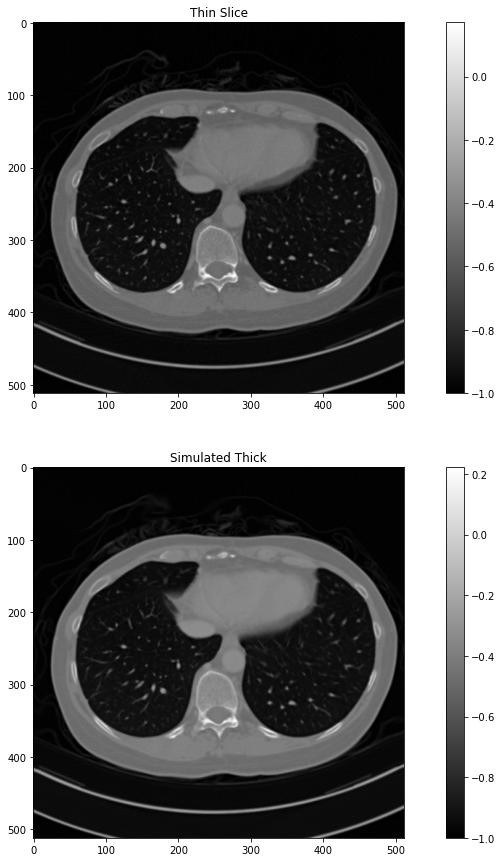

In [23]:
# Axial Plane Comparision
Aplane_idx = -1  
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
fig_thin = axs[0].imshow(test_thin[0,Aplane_idx,:,:], cmap = 'gray')
axs[0].set_title("Thin Slice");
fig_thick = axs[1].imshow(test_thick[0,Aplane_idx,:,:], cmap = 'gray')
axs[1].set_title("Simulated Thick");
fig.colorbar(fig_thin,ax=axs[0])
fig.colorbar(fig_thick,ax=axs[1])
print(f"The RMSE is: {rmse(test_thin[0,Aplane_idx,:,:].numpy(),test_thick[0,Aplane_idx,:,:].numpy())}")
print(f"The PSNR is: {psnr(test_thin[0,Aplane_idx,:,:].numpy(),test_thick[0,Aplane_idx,:,:].numpy())}")
print(f"The SSIM is: {ssim(test_thin[0,Aplane_idx,:,:].numpy(),test_thick[0,Aplane_idx,:,:].numpy())}")

The RMSE is: 0.04976425915451092
The PSNR is: 37.7967567564792
The SSIM is: 0.9345393577501061


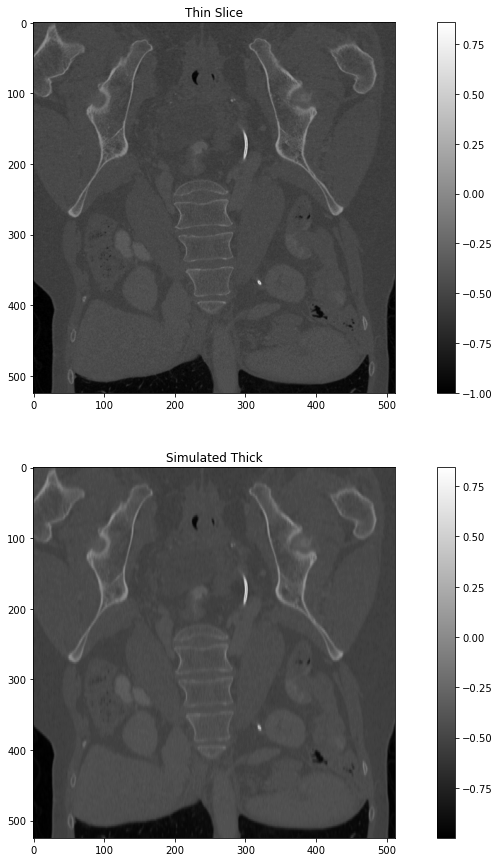

In [15]:
# Coronal Plane Comparision
Cplane_idx = 255  
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
fig_thin=axs[0].imshow(test_thin[0,:,Cplane_idx,:], cmap = 'gray')
axs[0].set_title("Thin Slice");
fig_thick=axs[1].imshow(test_thick[0,:,Cplane_idx,:], cmap = 'gray')
axs[1].set_title("Simulated Thick");
fig.colorbar(fig_thin,ax=axs[0])
fig.colorbar(fig_thick,ax=axs[1])
print(f"The RMSE is: {rmse(test_thin[0,:,Cplane_idx,:].numpy(),test_thick[0,:,Cplane_idx,:].numpy())}")
print(f"The PSNR is: {psnr(test_thin[0,:,Cplane_idx,:].numpy(),test_thick[0,:,Cplane_idx,:].numpy())}")
print(f"The SSIM is: {ssim(test_thin[0,:,Cplane_idx,:].numpy(),test_thick[0,:,Cplane_idx,:].numpy())}")

The RMSE is: 0.032871711229864556
The PSNR is: 38.816066343919864
The SSIM is: 0.9502541682177696


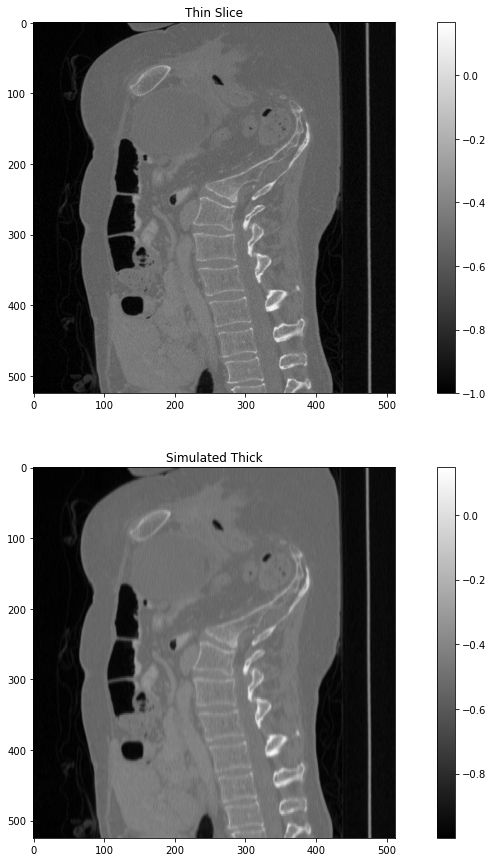

In [16]:
# Sagittal Plane Comparision
Splane_idx = 255  
fig, axs = plt.subplots(2, 1, figsize=(15, 15))
fig_thin = axs[0].imshow(test_thin[0,:,:,Splane_idx], cmap = 'gray')
axs[0].set_title("Thin Slice");
fig_thick = axs[1].imshow(test_thick[0,:,:,Splane_idx], cmap = 'gray')
axs[1].set_title("Simulated Thick");
fig.colorbar(fig_thin,ax=axs[0])
fig.colorbar(fig_thick,ax=axs[1])
print(f"The RMSE is: {rmse(test_thin[0,:,:,Splane_idx].numpy(),test_thick[0,:,:,Splane_idx].numpy())}")
print(f"The PSNR is: {psnr(test_thin[0,:,:,Splane_idx].numpy(),test_thick[0,:,:,Splane_idx].numpy())}")
print(f"The SSIM is: {ssim(test_thin[0,:,:,Splane_idx].numpy(),test_thick[0,:,:,Splane_idx].numpy())}")